# 설정

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 14.2 합성곱 층

- CNN에서 각 층은 2D로 표현되어 뉴런을 더 쉽게 연결 가능하다.  
- 이 때 제로 패딩(zero padding)을 이용해 높이와 너비를 이전 층과 같게 하기 위해 입력의 주위에 0을 추가하는 것이 일반적이다.  
- 스트라이드(stride)는 입력데이터에 필터를 적용하여 이동할 간격을 조절하는 것을 말한다. 즉, 필터(또는 합성곱 커널)가 이동할 간격을 의미한다.

## 14.2.1 필터

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F7XcQg%2FbtrgxC3hVGA%2FD7KNJ3FP5prpThIgyVkfFK%2Fimg.png" width="500" height="200">  
- CNN에서 이미지에서 특징들을 추출한 출력 데이터를 피처맵(feature map)이라 한다.  
- Input을 통해 피처맵을 얻기 위해 합성곱(convolution, 행렬과 행렬간 내적 계산) 과정을 거쳐야 한다. 이 때 Input과 합성곱이 될 아이템을 Filter라 하며 Kernerl이라 불리기도 한다. <u>즉, Filter는 이미지의 특성을 찾아내는 것이 목적이며 CNN에서 학습 대상이 Filter이다.</u>  

출처 : https://all-young.tistory.com/43

## 14.2.2 여러 가지 특성 맵 쌓기

- 하나의 합성곱 층이 입력에 여러 필터를 동시에 적용하여 입력에 있는 여러 특성을 감지할 수 있다.  
- 합성곱 층에 n개의 필터가 적용되면, 출력 데이터는 n개의 채널을 갖게 된다  
- 흑백 사진이라면 2차원 데이터로 1개 채널로 구성되지만, 컬러 사진이라면 RGB 3차원 데이터로 3개 채널을 구성하게 된다.  
<img src="https://taewanmerepo.github.io/2018/01/cnn/channel.jpg" width="500" height="300">  

출처 : http://taewan.kim/post/cnn/

## 14.2.3 텐서플로 구현

In [14]:
from sklearn.datasets import load_sample_image

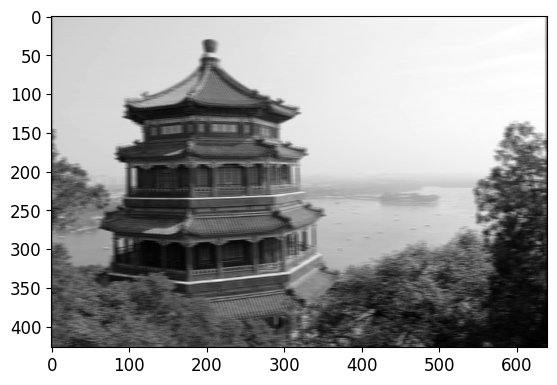

In [15]:
# 각 컬러 채널의 픽셀 강도는 0~255 byte로 표현되는데 이를 0~1의 실수로 바꿈
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 필터를 2개로 만듦
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32) # 2개의 7*7 필터 생성
filters[:, 3, :, 0] = 1 # 수직
filters[3, :, :, 1] = 1 # 수평

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # 첫 번째, 두 번째 특성 맵을 그림
plt.show()

`tf.nn.conv2d()`
- images : 입력의 미니배치  
- filters : 적용될 필터  
- strides : 1이나 4개의 원소를 갖는 1D 배열로 지정가능. 1D 배열의 가운데 2개의 원소는 수직, 수평 스트라이드.  
- padding : 'VALID' 또는 'SAME'  
  - 'VALID' : 합성곱 층에 재로 패딩x
  - 'SAME' : 필요한 경우 합성곱 층에 제로 패딩

In [9]:
# 3*3 크기의 32개의 필터와 stride 1, "same" 패딩을 사용하는 Conv2D 층을 만들고
# 출력을 위해 ReLu 활성화 함수 적용
cnn = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                          padding="same", activation="relu")

## 14.2.4 메모리 요구 사항

- CNN에서 합성곱 층이 많은 양의 RAM을 필요로 한다는 문제가 있다. 특히 훈련하는 동안에 역전파 알고리즘이 역방향 계산을 할 때 정방향에서 계산했던 모든 중간 값을 필요로 하기 때문이다.  
- 메모리 부족으로 훈련이 실패하면, 미니배치 크기를 줄이는 시도를 할 수 있다.  


# 14.3 풀링 층

- 풀링(pooling)은 2차원 데이터의 세로 및 가로 방향의 공간을 줄이는 연산이다.  
- 풀링층의 목적은 계산량과 메모리 사용량, 파라미터 수를 줄이기 위해 입력 이미지의 축소본을 만드는 것이다.  
- 학습해야 할 매개변수가 없으면, 입력 데이터의 채널 수 그대로 출력 데이터로 보내는 특징을 가진다.
- 풀링에는 최대 풀링(Max Pooling), 평균 풀링(Average Pooling) 등이 있다.  
  - 일반적으로 성능이 더 좋은 최대 풀링을 사용한다.  
  - 최대 풀링은 가장 큰 특징만 유지하여 다음 층이 조금 더 명확한 신호로 작업할 수 있다.  
  - 평균 풀링보다 강력한 이동 불변성을 제공하고 연산 비용이 조금 덜 든다.  

- 최대풀링은 작은 변화(회전, 확대, 축소)에도 일정 수준의 불변성을 가진다. 하지만 매우 파괴적이다라는 단점이 있다.  
  - ex. 작은 2*2 커널과 스트라이드 2를 사용하더라도, 출력은 양방향으로 절반이 줄어들어 입력값의 75%를 잃게 된다.  
<br>  

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99A50F395AAD46301B" width="500" height="200">  
- 위 그림은 2*2 최대 풀링을 스트라이드 2로 처리하는 과정을 보여준다.  

출처 : https://kolikim.tistory.com/54

## 14.3.1 텐서플로 구현

In [10]:
max_pool = keras.layers.MaxPool2D(pool_size=2) # max pooling, 평균 풀링 층 : AvgPool2D

In [17]:
output = tf.nn.max_pool(images, ksize=(1,1,1,3), strides=(1,1,1,3), padding="valid")

InvalidArgumentError: ignored

In [14]:
depth_pool = keras.layers.Lambda(
    lambda X : tf.nn.max_pool(X, ksize=(1,1,1,3), strides=(1,1,1,3), padding="valid")
)

In [19]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [21]:
global_avg_pool = keras.layers.Lambda(lambda X : tf.reduce_mean(X,axis=[1,2]))

# 14.4 CNN 구조

- 전형적인 CNN 구조는 합성곱 층을 몇 개 쌓고, 그 뒤 풀링층을 쌓고 그 다음에 합성곱층(+ReLU)을 몇 개 더 쌓고 또 풀링 층을 쌓는 구조이다.  
- 이미지는 점점 작아지지만, 합성곱 층으로 점점 더 깊어진다.  

In [23]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64,7, activation="relu", padding="same", # (1)
                        input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(2), # (2)
    keras.layers.Conv2D(128,3,activation="relu",padding="same"), # (3)
    keras.layers.Conv2D(128,3,activation="relu",padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256,3,activation="relu",padding="same"), # (4)
    keras.layers.Conv2D(256,3,activation="relu",padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(), # (5)
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

(1) 7*7 필터 64개, 스트라이드 1을 사용, 하나의 컬러 체널이므로 input size는 28 * 28 * 1로 지정  
(2) 풀링 크기가 2인 최대 풀링 층을 추가해 공간 방향 차원을 절반으로 줄임  
(3) 이미지가 클 때는 이 구조를 더 많이 반복할 수 있음  
(4) CNN이 출력층에 다다를수록 필터 개수가 늘어남  
(5) 2개의 은닉층과 하나의 출력층으로 구성된 완전 연결 네트워크. 밀집 네트워크는 샘플의 특성으로 1D 배열을 기대하므로 입력을 일렬로 펼쳐야 함. 또 밀집 층 사이에 과대적합을 줄이기 위해 50%의 드롭아웃 비율을 가진 드롭아웃 층 추가

 ※ ILSVRC 대회에서 우승한 모델 : AlexNext(2012), GoogLeNet(2014), ResNet(2015)  

## 14.4.1 LeNet-5

- 1998년에 얀 르쿤이 만들었으며 MNIST에 널리 사용되었다.  
<img src="https://user-images.githubusercontent.com/78655692/160420673-9a10abf3-d67f-4ec8-a450-4b978432ab0a.png" width="500" height="200">

- MNIST 이미지는 28 x 28 픽셀이지만 제로 때딩되어 32 X 32되고 네트워크에 주입되기 전에 정규화된다. 네트워크의 나머지 부분은 패딩을 사용하지 않는다 그래서 이미지가 네트워크를 따라 진행하면서 점차 크기가 줄어든다.  
- 평균 풀링 층은 조금 더 복잡하다. 각 뉴런은 입력의 평균을 계산한 다음, 그 값에 학습되는 계숫값(특성 맵마다 하나씩 존재)을 곱한다. 그리고 학습되는 값인 편항(역시 특성 맵마다 나씩 있음)을 더한다. 그런 다음 마지막으로 활성화 함수를 적용한다.  
- C3에 있는 대부분의 뉴런은 S2의 (6개 맵 전체가 아니라) 3개 또는 4개 맵에 있는 뉴런에만 연결된다.  
- 출력층은 조금 특별하다. 입력과 가중치 벡터를 행렬 곱셈하는 대신 각 뉴런에서 입력 벡터와 가중치 벡터 사이의 유클리드 거리를 출력한다. 각 출력은 이미지가 얼마나 특정 숫자 클래스에 속하는지 측정한다.

## 14.4.2 AlexNet

- 과대적합을 위해 두 가지 규제를 사용한다.  
  - (1) 훈련하는 동안 F9과 F10의 출력에 드롭아웃 50% 비율을 적용  
  - (2) 훈련 이미지를 랜덤하게 여러 간격으로 이동하거나 수평으로 뒤집고 조명을 바꾸는 식으로 데이터 증식을 수행  

<br>

-  <img src="https://user-images.githubusercontent.com/78655692/160421851-7f682d11-e4d9-4117-9c58-d1022d476658.png" width="500" height="200">

- C1과 C3 층의 ReLu 단계 후에 바로 LRN(local response normalization)이라 부르는 경쟁적인 정규화 단계를 사용한다.  
  - 가장 강하게 활성화된 뉴런이 다른 특성 맵에 있는 같은 위치의 뉴런을 억제  
  - 이는 특성 맵을 각기 특별하게 다른 것과 구분되게 하고, 더 넓은 시각에서 특징을 탐색하도록 만들어 결국 일반화 성능을 향상  

## 14.4.3 GoogLeNet

- 이전 CNN보다 훨씬 더 깊이가 깊다.  
- 인셉션 모듈이라는 서브 네트워크를 가지고 있어 이전 구조보다 훨씬 효과적으로 파라미터를 사용한다.  

   <img src="https://user-images.githubusercontent.com/78655692/160424823-e4e59d8e-9f36-4b3b-9ad0-291a261c069a.png" width="500" height="300">  
- 3 x 3 + 1(S) : 3x3 커널, 스트라이드1, "same" 패딩 사용을 의미  
- 두 번째 합성곱 층은 각기 다른 커널 크기 (1x1, 3x3, 5x5)를 사용해 다른 크기의 패턴을 잡음  
<br>

Q. 인셉션 모듈이 1x1 커널의 합성곱 층을 왜 가지는 것 일까?  
  - 공간 상의 패턴을 잡을 수는 없지만 깊이 차원을 따라 놓인 패턴을 잡을 수 있음  
  - 병목층의 역할을 담당. 연산 비용과 파라미터 개수를 줄여 훈련 속도를 높이고 일반화 성능을 향상  
  - 합성곱 층의 쌍([1x1, 3x3]과 [1x1, 5x5])이 더 복잡한 패턴을 감지할 수 있는 한 개의 강력한 합성곱 층처럼 작동  
  
<br>

[GoogLeNet 구조]  
<img src="https://user-images.githubusercontent.com/78655692/160425239-9f5da110-7322-442d-bb84-0dd0e60162ed.png" width="500" height="400">  

## 14.4.4 VGGNet

<img src="https://user-images.githubusercontent.com/78655692/174040823-4dfb4e99-9fa8-4f6f-9db3-c2051f4fe0fe.png" width="500" height="400">  
- 2,3개의 합성곱 층 뒤에 풀링 층이 나오고, 다시 2,3개 합성곱 층과 풀링 층이 나오는 구조이다.  
- 마지막 밀집 네트워크는 2개의 은닉층과 출력층으로 이루어진다.  
- 많은 개수의 필터를 사용하지만 3x3 필터만 사용한다.  
  - 3개의 3x3 컨볼루션 레이어의 스택은 하나의 7x7 컨볼루션 레이어와 동일한 효과적인 수용 필드(receptive field)를 가짐  
  - 깊어질수록, 더 많은 비선형 함수가 더 많이 들어가서 decision function이 더 잘 학습됨  
  - 7x7 컨볼루션보다 더 적은 파라미터로 학습할 수 있음  

출처 : https://ingu627.github.io/hands_on/TDL6/#1441-lenet-5  

## 14.4.5 ResNet

- 잔차 네트워크(Residual Network) 사용  
- 우승한 네트워크는 152개 층으로 구성된 극도로 깊은 CNN 사용(ResNet-152)
- 이런 깊은 네트워크를 훈련시킬 수 있는 핵심 요소는 스킵 연결(skip connection)
  - 어떤 층에 주입되는 신호가 상위 층의 출력에도 더해짐
- 잔차 학습(Residual Learning) : 신경망을 훈련시킬 때는 목적 함수 h(x)를 모델링하는 것이 목표인데, 입력 x를 네트워크의 출력에 더한다면(=스킵 연결 추가) 네트워크는 h(x)대신 f(x)=h(x)-x를 학습  
- 일반적인 신경망을 초기화할 때는 가중치가 0에 가깝기 때문에 네트워크도 0에 가까운 값을 출력한다.  
- 스킵 연결을 추가하면 이 네트워크는 입력과 같은 값을 출력한다.  
- 잔차 유닛(residual unit) : 스킵 연결을 가진 작은 신경망  
<img src="https://user-images.githubusercontent.com/78655692/160428399-46e26455-a55b-4f65-ba39-ae5c98020463.png" width="500" height="300">  

- RU를 활용한 잔차학습으로 스킵 연결로 인한 보다 수월한 학습 가능하다.  
<img src="https://user-images.githubusercontent.com/78655692/160428750-2a427d47-b736-4c81-85c2-bf637c6ccc02.png" width="400" height="300">  
- ResNet 구조  
<img src="https://user-images.githubusercontent.com/78655692/160429004-d13c396b-3f2e-4065-bfbe-88f1493333de.png" width="500" height="300">  
- GoogLeNet과 똑같이 시작하고 종료하지만 중간에 단순한 잔차 유닛을 매우 깊게 쌓았다.
<img src="https://user-images.githubusercontent.com/78655692/160429318-66098142-d3c6-4078-8610-1c686dc2e42e.png" width="500" heigh="300">  
- 특성 맵의 수는 몇 개의 잔차 유닛마다 두 배로 늘어난다.
- 반면 높이와 너비는 절반이 된다.
  - 이러한 경우 입력과 출력의 크기가 다르기 때문에 입력이 잔차 유닛의 출력에 바로 더해질 수 없음
  - 이 문제를 해결하기 위해 stride 2이고 출력 틍성 맵의 수가 같은 1x1 합성곱 층으로 입력을 통과시킴 (그림)

<br>

- Inception-v4 : GooLeNet + ResNet 모델의 합성  

<br>

---
출처 : https://ingu627.github.io/hands_on/TDL6/#1441-lenet-5


## 14.4.6 Xception

https://kdeon.tistory.com/43#14.%204.%206%20Xception-1

## 14.4.7 SeNet

https://kdeon.tistory.com/43#14.%204.%206%20Xception-1

# 14.5 케라스를 사용해 ResNet-34 CNN 구현하기  

In [9]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [10]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [11]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit_2 (ResidualUn  (None, 56, 56, 64)       74240     
 it)                                                             
                                                      

# 14.6 케라스에서 제공하는 사전훈련된 모델 사용하기

In [12]:
# 이미지넷 데이터셋에서 사전훈련된 ResNet-50 모델 로드
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 0s 0us/step


In [16]:
images_resized = tf.image.resize(images, [224,224]) # ResNet-50 모델은 224*224 픽셀 크기이 미이지를 기대

In [18]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

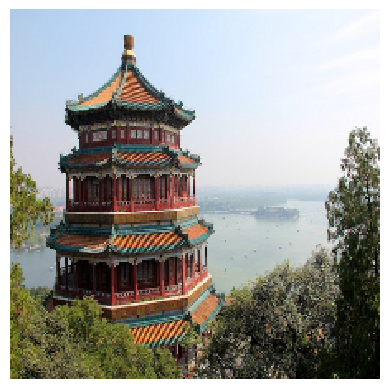

In [19]:
plot_color_image(images_resized[0])
plt.show()

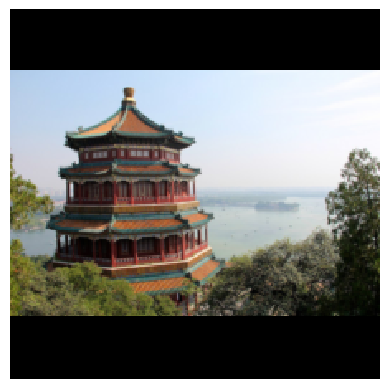

In [20]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

In [21]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

1/1 [==============================] - 2s 2s/step


In [22]:
Y_proba.shape

(2, 1000)

In [23]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #0
  n03028079 - church       26.16%
  n04346328 - stupa        23.96%
  n02980441 - castle       17.40%

Image #1
  n11939491 - daisy        15.94%
  n03530642 - honeycomb    15.28%
  n04522168 - vase         9.32%



# 14.7 사전훈련된 모델을 사용한 전이 학습

### 데이터 로드 및 info 확인

In [24]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [25]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [26]:
dataset_size

3670

In [44]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers",
                                                       split = ["train[:10%]", "train[10%:25%]", "train[25%:]"],
                                                       as_supervised = True)

### 이미지 전처리

In [32]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224,224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

- 훈련 세트 섞은 후 위 전처리 함수를 3개 데이터셋(train_set, valid_set, test_set)에 적용  
- 배치 크기 지정 및 prefetch 적용  

In [46]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()

train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

### imagenet에서 사전훈련된 Xception 모델 로드

inclue_top = False 지정시, 네트워크 최상층에 해당하는 전역 평균 풀링 층과 밀집 출력 층 제외된다.  
- 이 기반 모델의 출력을 바탕으로 새로운 전역 평균 풀링 층을 추가하고, 그 뒤에 클래스마다 하나의 유닛과 소프트맥스 활성화 함수를 가진 밀집 출력 층을 놓음  

케라스의 Model 클래스 객체 생성

In [47]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

훈련 초기에는 사전훈련된 층의 가중치 동결

In [48]:
for layer in base_model.layers:
  layer.trainable = False

### 모델 컴파일 및 훈련

In [51]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

ValueError: ignored

### 동결 해제 후 훈련

In [52]:
for layer in base_model.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data = valid_set)

ValueError: ignored

출처 : https://kdeon.tistory.com/44#14.%207%20%EC%82%AC%EC%A0%84%ED%9B%88%EB%A0%A8%EB%90%9C%20%EB%AA%A8%EB%8D%B8%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EC%A0%84%EC%9D%B4%20%ED%95%99%EC%8A%B5-1

# 14.8 분류와 위치 추정

사진에서 물체의 위치를 추정하는 것은 회귀 작업으로 가능  
- 물체를 둘러싸는 바운딩 박스를 추정  
- 바운딩 박스를 예측하는 일반적인 방법은 물체 중심의 수평, 수직 좌표와 높이, 너비를 예측  

<br>

일반적으로 전역 평균 풀링 층 위에 4개의 유닛을 가진 두 번째 밀집 출력층을 추가하고 MSE 손실을 사용해 훈련  

In [54]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=["accuracy"])

NameError: ignored

- 바운딩 박스를 추정하기 위해 데이터가 바운딩 박스 레이블을 가지고 있어야 함  
- 꽃 데이터셋은 꽃 주위에 바운딩 박스를 가지고 있지 않음  
   - 레이블을 만드는 건 비용이 많이 듦  
   - 이미지에 바운딩 박스를 추가하기 위해 오픈소스 이미지 레이블 도구나 이미지가 매우 많다면 크라우드소싱 플랫폼을 고려해볼 수 있음  


- 꽃 데이터셋의 모든 이미지에 대해 바운딩 박스가 준비되어있다고 가정  
  - 클래스 레이블, 바운딩 박스와 함께 전처리된 이미지의 배치가 하나의 원소인 데이터셋을 만들어야 함  
  - 각 원소는 (images, (class_labels, boungding_boxes)) 형태의 튜플이 됨  


모델 훈련 시 손실함수로 MSE 외에, 좋은 지표로 IoU 사용  
- 바운딩 박스를 얼마나 잘 예측하는지 평가하는 데 널리 사용됨  
- IoU값은 예측한 바운딩 박스와 타깃 바운딩 박스 사이에 중첩되는 영역을 전체 영역을 나눈 것  

---

출처 : https://kdeon.tistory.com/45

# 14.9 객체 탐지

출처 : https://kdeon.tistory.com/45

객체 탐지는 하나의 이미지에서 여러 물체를 분류하고 위치를 추정하는 작업이다.  

- 이전에 널리 사용되던 방법은 하나의 물체를 분류하고 위치를 찾는 분류기를 훈련한 후, 이미지를 모두 훑는 것이다.  
- 완전 합성곱 신경망(FCN)을 사용해 CNN을 빠르게 이미지에 슬라이딩시킬 수 있다.  

[mAP]  
- mAP(mean average precision)는 객체 탐지에서 널리 사용되는 평가 지표이다.  

## 14.9.1 완전 합성곱 신경망  
- FCN, Fullly Convolutional Networks  
- 2015년 시맨틱 분할을 위한 논문에서 소개된 아이디어  
- CNN 맨 위의 밀집 층을 합성곱 층으로 바꿀 수 있다.  
- FCN은 합성곱 층만 가지므로 어떤 크기의 이미지에서도 훈련/실행 가능하다.  

## 14.9.2 YOLO

- 2015년 제안된 매우 빠르고 정확한 객체 탐지 구조  
- 이후 2016년 YOLOv2, YOLOv3에서 향상된다.  
- 매우 빠른 알고리즘으로 실시간 비디오에 적용 가능하다.  

[YOLOv3 구조]  
- 각 격자 셀마다 1개가 아닌 5개의 바운딩 박스 출력한다.  
- 바운딩 박스 중심의 절대 좌표 예측이 아닌 격자 셀에 대한 상대 좌표 예측한다.  
- 신경망을 훈련하기 전에, YOLOv3는 앵커 박스(사전 바운딩 박스)라 부르는 5개의 대표 바운딩 박스 크기를 찾는다.  
- 네트워크가 다른 스케일을 가진 이미지를 사용하여 훈련된다.  



# 14.10 시맨틱 분할

- 물체가 속한 클래스에 따라 이미지의 모든 픽셀을 분류하는 작업이다.  
- 이미지가 일반적인 CNN을 통과할 때 점진적으로 위치 정보를 잃는 다는 점이 가장 어렵다.  